<a href="https://colab.research.google.com/github/Anvikarp/knitvcrochet/blob/main/Deep_CNN_(Knit_vs_Crochet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Knit vs Crochet Image Classifier

A CNN model to classify images of knitted vs crocheted items.

## Setup

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import random

In [ ]:
!pip install pydot


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Load the data

In [ ]:
data_dir = '/home/karp/Downloads/knitvcrochet/'

In [ ]:
print("Contents of data directory:")
for item in os.listdir(data_dir):
    item_path = os.path.join(data_dir, item)
    if os.path.isdir(item_path):
        num_files = len([f for f in os.listdir(item_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"  {item}/: {num_files} images")

Contents of data directory:
  Knit/: 1121 images
  Crochet/: 1188 images


## Generate a Dataset

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2309 files belonging to 2 classes.
Using 1848 files for training.
Using 461 files for validation.


In [ ]:
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Class names: ['Crochet', 'Knit']


In [ ]:
# Calculate dataset statistics
total_train_samples = len(list(train_ds.unbatch()))
total_val_samples = len(list(val_ds.unbatch()))
print(f"Training samples: {total_train_samples}")
print(f"Validation samples: {total_val_samples}")
print(f"Total samples: {total_train_samples + total_val_samples}")

Training samples: 1848
Validation samples: 461
Total samples: 2309


## Visualize the data

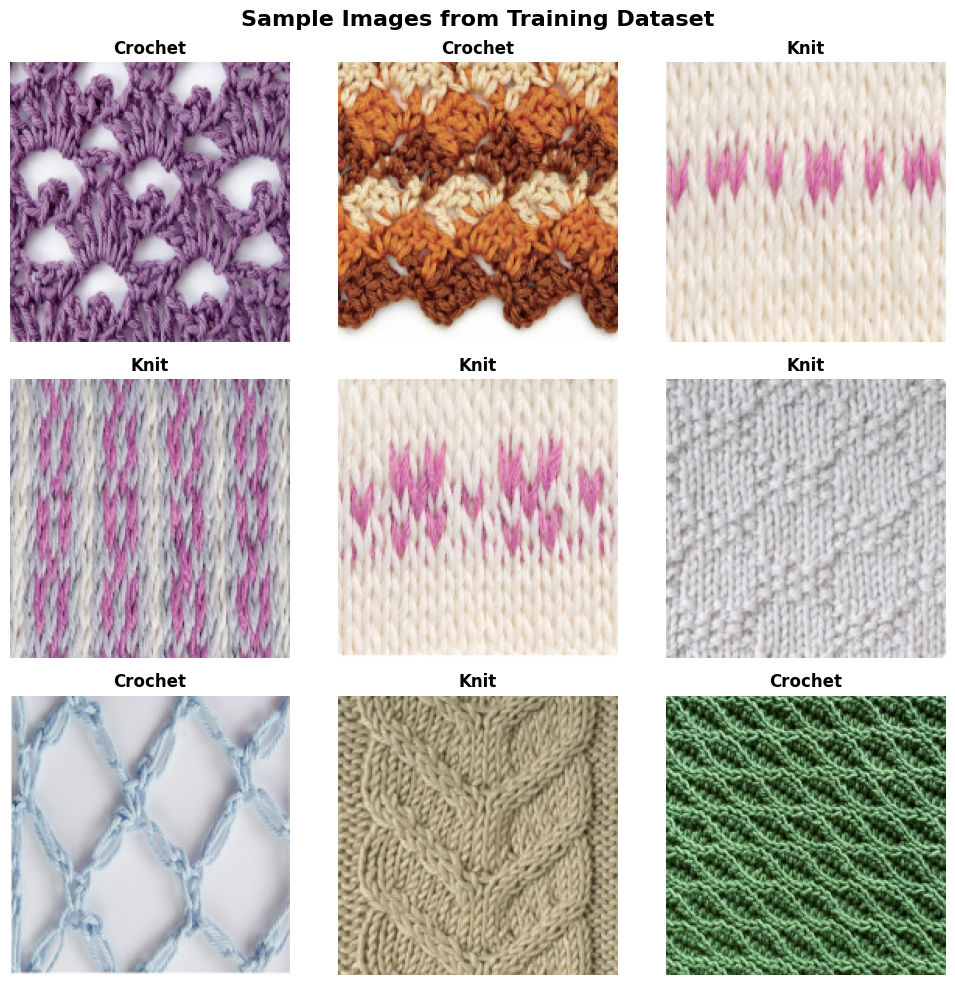

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(f"{class_names[int(labels[i])]}", fontsize=12, fontweight='bold')
        plt.axis("off")
plt.suptitle("Sample Images from Training Dataset", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Data Augmentation


In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


### Visualize the augmentation for 1 image

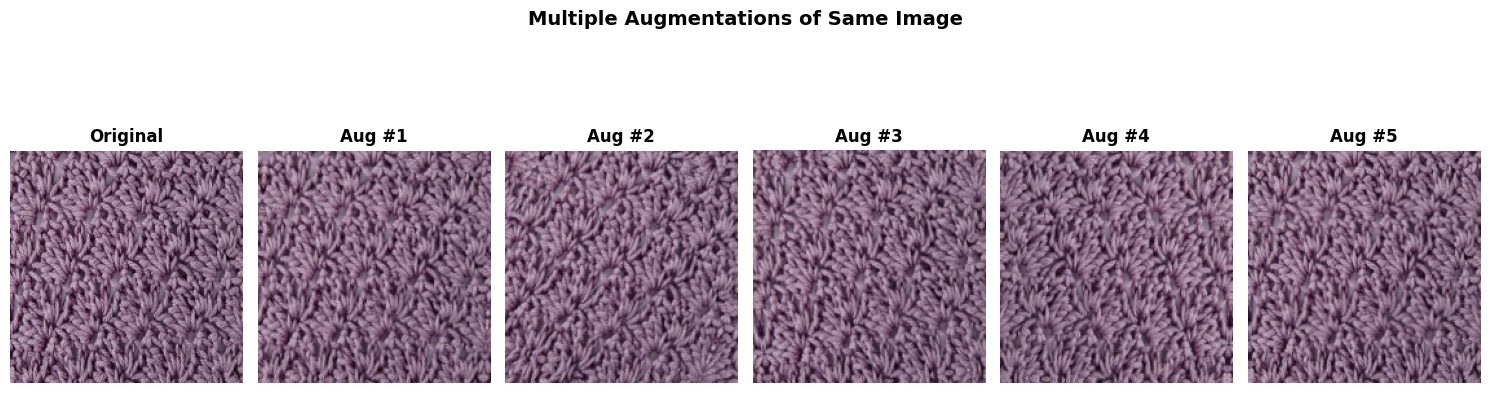

In [ ]:
# Show multiple augmentations of the same image
plt.figure(figsize=(15, 5))
for images, labels in train_ds.take(1):
    original_image = images[0:1]
    plt.subplot(1, 6, 1)
    plt.imshow(np.array(original_image[0]).astype("uint8"))
    plt.title("Original", fontweight='bold')
    plt.axis("off")

    for i in range(5):
        augmented_images = data_augmentation(original_image)
        ax = plt.subplot(1, 6, i + 2)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.title(f"Aug #{i+1}", fontweight='bold')
        plt.axis("off")
    break

plt.suptitle("Multiple Augmentations of Same Image", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build a model

In [ ]:
# Normalize pixels to [0,1]
normalization_layer = layers.Rescaling(1./255)

# Build a simple CNN
def build_simple_cnn(shape, classes):
    inputs = keras.Input(shape=shape)
    x = normalization_layer(inputs)

    # 3 conv blocks: 32 → 64 → 128 filters
    for filters in [32, 64, 128]:
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)

    if classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(x)
    else:
        outputs = layers.Dense(classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

# Instantiate model
num_classes = len(class_names)
model = build_simple_cnn(image_size + (3,), num_classes)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │     3,964,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,305 (15.48 MB)

 Trainable params: 4,058,305 (15.48 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [ ]:
# Compile
if num_classes == 2:
    loss = "binary_crossentropy"
    metrics = ["accuracy"]
else:
    loss = "sparse_categorical_crossentropy"
    metrics = ["accuracy"]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=loss,
    metrics=metrics,
)

# Callbacks
epochs = 25
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, verbose=1,
        mode="min", restore_best_weights=True,
    ),
]

# Train
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


2025-09-28 14:32:38.458377: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,180,180]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,180,180]{3,2,1,0} %bitcast.4865, f32[32,3,3,3]{3,2,1,0} %bitcast.4682, f32[32]{0} %bitcast.5246), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_5_1/conv2d_20_1/convolution" source_file="/home/karp/mlenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-28 14:32:38.580775: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentia

57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5306 - loss: 0.7063

2025-09-28 14:32:46.697971: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.9 = (f32[24,32,180,180]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,180,180]{3,2,1,0} %bitcast.4865, f32[32,3,3,3]{3,2,1,0} %bitcast.4682, f32[32]{0} %bitcast.5246), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_5_1/conv2d_20_1/convolution" source_file="/home/karp/mlenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-28 14:32:46.792043: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentia

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5311 - loss: 0.7060

2025-09-28 14:32:51.711449: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,180,180]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,180,180]{3,2,1,0} %bitcast.420, f32[32,3,3,3]{3,2,1,0} %bitcast.427, f32[32]{0} %bitcast.429), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_5_1/conv2d_20_1/convolution" source_file="/home/karp/mlenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-28 14:32:51.800880: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially

58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.5315 - loss: 0.7057 - val_accuracy: 0.6009 - val_loss: 0.6688
Epoch 2/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.5977 - loss: 0.6638 - val_accuracy: 0.6421 - val_loss: 0.6691
Epoch 3/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.6376 - loss: 0.6364 - val_accuracy: 0.7050 - val_loss: 0.5852
Epoch 4/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6949 - loss: 0.5900 - val_accuracy: 0.7332 - val_loss: 0.5585
Epoch 5/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7531 - loss: 0.5267 - val_accuracy: 0.7158 - val_loss: 0.5966
Epoch 6/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.7977 - loss: 0.4499 - val_accuracy: 0.7831 - val_loss: 0.4782
Epoch 7/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8175 - loss: 0.4411 - val_accuracy: 0.8373 - val_loss: 0.3976
Epoch 8/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8530 - loss: 0.3801 - val_accuracy: 0.8265 - val_loss: 

## Run inference on new data

In [ ]:
# Find multiple sample images to test with
sample_images = []
sample_folders = []
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    for fname in os.listdir(folder_path)[:2]:  # Get 2 images per class
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            sample_images.append(os.path.join(folder_path, fname))
            sample_folders.append(folder_name)

# Shuffle samples so you don’t always grab the same images
combined = list(zip(sample_images, sample_folders))
random.shuffle(combined)
sample_images, sample_folders = zip(*combined) if combined else ([], [])

Testing on 4 sample images...


2025-09-28 14:34:53.686881: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.9 = (f32[1,32,180,180]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,180,180]{3,2,1,0} %bitcast.234, f32[32,3,3,3]{3,2,1,0} %bitcast.241, f32[32]{0} %bitcast.243), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_5_1/conv2d_20_1/convolution" source_file="/home/karp/mlenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-28 14:34:53.741725: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially b

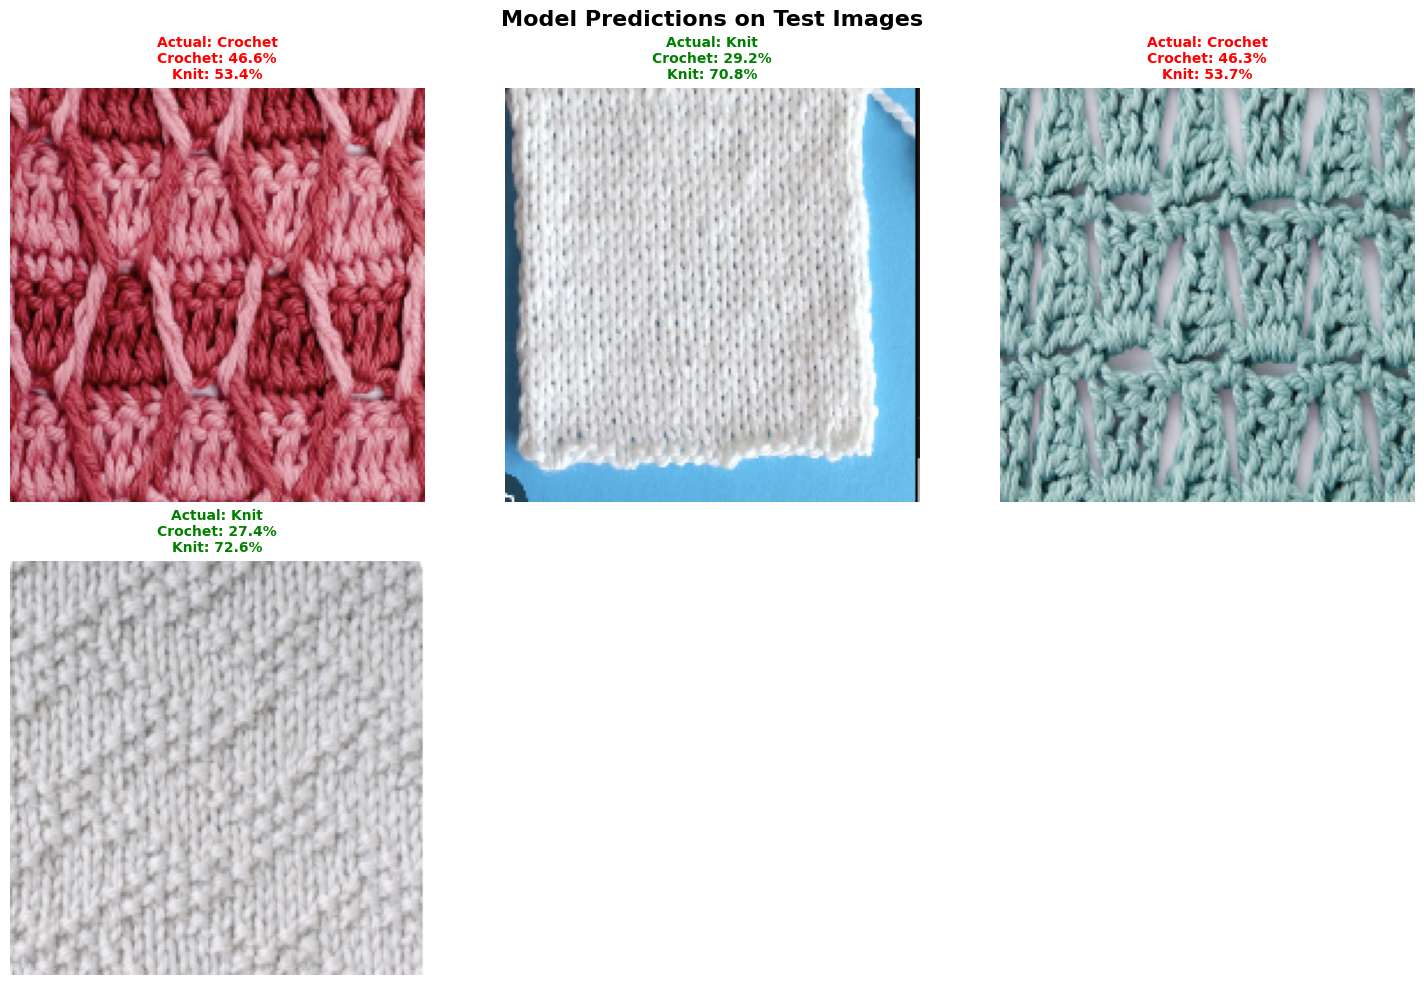


 Detailed prediction for: Screenshot 2025-09-28 at 12.13.46 PM.png
--------------------------------------------------
   • Crochet: 46.64%
   • Knit: 53.36%
   • Predicted: Knit (Confidence: 53.4%)


In [ ]:
if sample_images:
    print(f"Testing on {len(sample_images)} sample images...")

    # Grid of test images with predictions
    num_samples = min(6, len(sample_images))
    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(sample_images[:num_samples]):
        img = keras.utils.load_img(img_path, target_size=image_size)
        img_array = keras.utils.img_to_array(img)
        img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

        predictions = model.predict(img_array, verbose=0)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)

        # Prediction results
        if num_classes == 2:
            score = float(keras.ops.sigmoid(predictions[0][0]))
            pred_text = f"{class_names[0]}: {100 * (1 - score):.1f}%\n{class_names[1]}: {100 * score:.1f}%"
            actual_class = sample_folders[i]
            predicted_class = class_names[1] if score > 0.5 else class_names[0]
        else:
            scores = keras.ops.softmax(predictions[0])
            pred_lines = []
            for j, class_name in enumerate(class_names):
                pred_lines.append(f"{class_name}: {100 * float(scores[j]):.1f}%")
            pred_text = "\n".join(pred_lines)
            actual_class = sample_folders[i]
            predicted_class = class_names[np.argmax(scores)]

        # Color code the title based on correct/incorrect prediction
        title_color = 'green' if actual_class.lower() == predicted_class.lower() else 'red'
        plt.title(f"Actual: {actual_class}\n{pred_text}",
                 color=title_color, fontsize=10, fontweight='bold')
        plt.axis("off")

    plt.suptitle("Model Predictions on Test Images", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Results for first image
    img_path = sample_images[0]
    img = keras.utils.load_img(img_path, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)
    predictions = model.predict(img_array, verbose=0)

    print(f"\n Detailed prediction for: {os.path.basename(img_path)}")
    print("-" * 50)

    if num_classes == 2:
        score = float(keras.ops.sigmoid(predictions[0][0]))
        print(f"   • {class_names[0]}: {100 * (1 - score):.2f}%")
        print(f"   • {class_names[1]}: {100 * score:.2f}%")
        confidence = max(score, 1-score) * 100
        predicted = class_names[1] if score > 0.5 else class_names[0]
        print(f"   • Predicted: {predicted} (Confidence: {confidence:.1f}%)")
    else:
        scores = keras.ops.softmax(predictions[0])
        for i, class_name in enumerate(class_names):
            print(f"   • {class_name}: {100 * float(scores[i]):.2f}%")
        predicted_idx = np.argmax(scores)
        confidence = float(scores[predicted_idx]) * 100
        print(f"   • Predicted: {class_names[predicted_idx]} (Confidence: {confidence:.1f}%)")

else:
    print("No sample images found for testing.")

In [ ]:
print("Evaluating model on validation dataset:")
loss, accuracy = model.evaluate(val_ds)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Evaluating model on validation dataset:
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8828 - loss: 0.2985
Validation Loss: 0.3060
Validation Accuracy: 0.8894
